In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRanker

In [2]:
df = pd.read_csv("SuperMarketAnalysis.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [3]:
df["Hour"] = pd.to_datetime(df["Time"]).dt.hour

df.drop(columns=[
    "Invoice ID", "Date", "Time", "Tax 5%", "Sales", "cogs",
    "gross margin percentage", "gross income"
], inplace=True)

encoding_maps = {}
for col in ["Branch", "City", "Customer type", "Gender", "Product line", "Payment"]:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    encoding_maps[col] = mapping
    print(f"\nEncoding for '{col}':")
    for label, code in mapping.items():
        print(f"{label} → {code}")


Encoding for 'Branch':
Alex → 0
Cairo → 1
Giza → 2

Encoding for 'City':
Mandalay → 0
Naypyitaw → 1
Yangon → 2

Encoding for 'Customer type':
Member → 0
Normal → 1

Encoding for 'Gender':
Female → 0
Male → 1

Encoding for 'Product line':
Electronic accessories → 0
Fashion accessories → 1
Food and beverages → 2
Health and beauty → 3
Home and lifestyle → 4
Sports and travel → 5

Encoding for 'Payment':
Cash → 0
Credit card → 1
Ewallet → 2


C:\Users\Asus\AppData\Local\Temp\ipykernel_18008\3334307975.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Hour"] = pd.to_datetime(df["Time"]).dt.hour


In [4]:
X = df.drop(columns=["Quantity"])
y = df["Quantity"]
group = [len(X)]  
model = XGBRanker(
    objective="rank:pairwise",
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8)

model.fit(X, y, group=group)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.8, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, feature_weights=None,
          gamma=None, grow_policy=None, importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=6, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, ...)

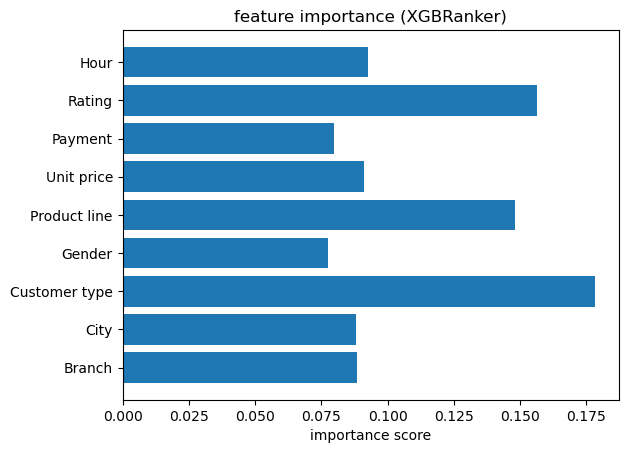

In [5]:
plt.figure()
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("importance score")
plt.title("feature importance (XGBRanker)")
plt.show()

In [6]:
product_sales = df.groupby("Product line")["Quantity"].sum().sort_values(ascending=False)
decoded_product_sales = product_sales.rename(index={v: k for k, v in encoding_maps["Product line"].items()})
print("Total quantity sold per product line:")
print(decoded_product_sales)

Total quantity sold per product line:
Product line
Electronic accessories    971
Food and beverages        952
Sports and travel         920
Home and lifestyle        911
Fashion accessories       902
Health and beauty         854
Name: Quantity, dtype: int64


In [7]:
df["Price_Category"] = pd.cut(df["Unit price"], bins=[10, 20, 30, 50, 70, 90], labels=["10-20", "20-30","30-50", "50-70", "70-90"])
price_analysis = df.groupby("Price_Category")["Quantity"].mean().sort_values(ascending=False)
print("Average quantity sold by price category:")
print(price_analysis)

Average quantity sold by price category:
Price_Category
70-90    5.693333
20-30    5.576271
10-20    5.528302
50-70    5.435407
30-50    5.372093
Name: Quantity, dtype: float64


C:\Users\Asus\AppData\Local\Temp\ipykernel_18008\1173486048.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_analysis = df.groupby("Price_Category")["Quantity"].mean().sort_values(ascending=False)


In [8]:
hourly_sales = df.groupby("Hour")["Quantity"].sum().sort_values(ascending=False)
print("Total quantity sold by hour:")
print(hourly_sales)

Total quantity sold by hour:
Hour
19    649
13    585
15    530
10    525
11    513
12    501
14    495
18    475
16    420
17    415
20    402
Name: Quantity, dtype: int64


In [9]:
payment_avg = df.groupby("Payment")["Quantity"].mean().sort_values(ascending=False)
decoded_payment_avg = payment_avg.rename(index={v: k for k, v in encoding_maps["Payment"].items()})
print("Average quantity sold by payment method:")
print(decoded_payment_avg)

Average quantity sold by payment method:
Payment
Credit card    5.536977
Cash           5.511628
Ewallet        5.484058
Name: Quantity, dtype: float64


In [27]:
df["Combined_Feature"] = (
    df["Product line"].astype(str) + " " +
    df["Payment"].astype(str) + " " +
    df["Customer type"].astype(str) + " " +
    df["City"].astype(str) + " " +
    df["Branch"].astype(str) + " " +
    df["Rating"].astype(str) + " " +
    df["Hour"].astype(str))

vectorizer = CountVectorizer()
feature_vector = vectorizer.fit_transform(df["Combined_Feature"])

In [11]:
n_recommended = 5
product_index = 555

In [12]:
nearest = NearestNeighbors(n_neighbors=n_recommended).fit(feature_vector)
similar_products = nearest.kneighbors(feature_vector[product_index])[1][0]
print("KNN Recommendations:")
print(df.iloc[similar_products][["Product line", "Quantity", "Payment", "Customer type"]])

KNN Recommendations:
     Product line  Quantity  Payment  Customer type
384             2         5        2              1
385             5         1        0              0
357             5        10        0              1
337             5         6        0              1
379             0         4        1              1


In [13]:
similarities = cosine_similarity(feature_vector)
similar_index = np.argsort(similarities[product_index])[::-1]
idx_recommended = similar_index[1:n_recommended + 1]
print("Cosine Similarity Recommendations:")
print(df.iloc[idx_recommended][["Product line", "Quantity", "Payment", "Customer type"]])

Cosine Similarity Recommendations:
     Product line  Quantity  Payment  Customer type
534             4         5        2              1
594             5         3        0              0
585             3         4        1              1
578             3         4        0              1
567             1         9        0              1
